In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import pickle

In [9]:

df = pd.read_csv('DATA7_SIEBERT_PREPOCESSED.csv')
df

,user_id,username,rating,original_text,gmap_id,business_name,translated_text,wcount,sentiment_label,sentiment_score,emoji_text,expanded_text,sentences,word_tokens,punctuation_removed,pos_tags,lemmatized,no_stopwords,lemma_fix,stop_fix,final_with_stopword,final_no_stopword,ori_wc,final_wc,final_no_stopword_wc
0,1.021213e+20,Shana Smith,5.0,Will have to come again soon..due for another cut,0x8805428f9ca29317:0x4122efd1046de654,Supercuts,Will have to come again soon..due for another cut,9,NEGATIVE,0.999488,Will have to come again soon..due for another cut,Will have to come again soon..due for another cut,['Will have to come again soon..due for anothe...,"[['will', 'have', 'to', 'come', 'again', 'soon...","[['will', 'have', 'to', 'come', 'again', 'soon...","[[('will', 'MD'), ('have', 'VB'), ('to', 'TO')...","[['will', 'have', 'to', 'come', 'again', 'soon...","[['come', 'soon', '..', 'due', 'another', 'cut']]","[['will', 'have', 'to', 'come', 'again', 'soon...","[['come', 'soon', 'due', 'another', 'cut']]",will have to come again soon due for another cut,come soon due another cut,9,10,5
1,1.016310e+20,Brittiny Beil,5.0,I started my run with treatment at meadow Cree...,0x52b247197357f7f7:0x66d0d92cf109a1d5,Meadow Creek,I started my run with treatment at meadow Cree...,91,POSITIVE,0.998918,I started my run with treatment at meadow Cree...,I started my run with treatment at meadow Cree...,['I started my run with treatment at meadow Cr...,"[['i', 'started', 'my', 'run', 'with', 'treatm...","[['i', 'started', 'my', 'run', 'with', 'treatm...","[[('i', 'NN'), ('started', 'VBD'), ('my', 'PRP...","[['i', 'start', 'my', 'run', 'with', 'treatmen...","[['start', 'run', 'treatment', 'meadow', 'cree...","[['i', 'start', 'my', 'run', 'with', 'treatmen...","[['start', 'run', 'treatment', 'meadow', 'cree...",i start my run with treatment at meadow creek ...,start run treatment meadow creek 2012 end run ...,91,95,51
2,1.056987e+20,Michael Reagan,5.0,I like the professional but also friendly staf...,0x8858272f5a118b01:0xaa680edfef593625,AFC Urgent Care - Bon Secours - Simpsonville,I like the professional but also friendly staf...,46,POSITIVE,0.998923,I like the professional but also friendly staf...,I like the professional but also friendly staf...,['I like the professional but also friendly st...,"[['i', 'like', 'the', 'professional', 'but', '...","[['i', 'like', 'the', 'professional', 'but', '...","[[('i', 'NN'), ('like', 'IN'), ('the', 'DT'), ...","[['i', 'like', 'the', 'professional', 'but', '...","[['like', 'professional', 'also', 'friendly', ...","[['i', 'like', 'the', 'professional', 'but', '...","[['like', 'professional', 'also', 'friendly', ...",i like the professional but also friendly staf...,like professional also friendly staff location...,46,46,23
3,1.054290e+20,Maureen Linker,5.0,I can't give enough praise for Dr K and her wo...,0x54950e4f37f2f0e1:0x2dd2b51972a685db,Prestige Family Dentistry,I can't give enough praise for Dr K and her wo...,94,POSITIVE,0.998932,I can't give enough praise for Dr K and her wo...,I cannot give enough praise for Dr K and her w...,['I cannot give enough praise for Dr K and her...,"[['i', 'can', 'not', 'give', 'enough', 'praise...","[['i', 'can', 'not', 'give', 'enough', 'praise...","[[('i', 'NN'), ('can', 'MD'), ('not', 'RB'), (...","[['i', 'can', 'not', 'give', 'enough', 'praise...","[['not', 'give', 'enough', 'praise', 'dr', 'k'...","[['i', 'can', 'not', 'give', 'enough', 'praise...","[['not', 'give', 'enough', 'praise', 'dr', 'k'...",i can not give enough praise for dr k and her ...,not give enough praise dr k wonderful staff sh...,94,95,50
4,1.002408e+20,Adriana Bohorquez,5.0,Love the amenities. My son asks me everyday to...,0x89b7fecef6f95e49:0xac324c8a4514eab,The Y in Pasadena,Love the amenities. My son asks me everyday to...,13,POSITIVE,0.998877,Love the amenities. My son asks me everyday to...,Love the amenities. My son asks me everyday to...,"['Love the amenities.', 'My son asks me everyd...","[['l

In [10]:
#calculate high confidence review
high_df = df[df['sentiment_score'] >= 0.90].copy()
low_df = df[df['sentiment_score'] < 0.90].copy()

print(len(high_df))
print(len(low_df))

1222986
1711


In [11]:
df = high_df
df

,user_id,username,rating,original_text,gmap_id,business_name,translated_text,wcount,sentiment_label,sentiment_score,emoji_text,expanded_text,sentences,word_tokens,punctuation_removed,pos_tags,lemmatized,no_stopwords,lemma_fix,stop_fix,final_with_stopword,final_no_stopword,ori_wc,final_wc,final_no_stopword_wc
0,1.021213e+20,Shana Smith,5.0,Will have to come again soon..due for another cut,0x8805428f9ca29317:0x4122efd1046de654,Supercuts,Will have to come again soon..due for another cut,9,NEGATIVE,0.999488,Will have to come again soon..due for another cut,Will have to come again soon..due for another cut,['Will have to come again soon..due for anothe...,"[['will', 'have', 'to', 'come', 'again', 'soon...","[['will', 'have', 'to', 'come', 'again', 'soon...","[[('will', 'MD'), ('have', 'VB'), ('to', 'TO')...","[['will', 'have', 'to', 'come', 'again', 'soon...","[['come', 'soon', '..', 'due', 'another', 'cut']]","[['will', 'have', 'to', 'come', 'again', 'soon...","[['come', 'soon', 'due', 'another', 'cut']]",will have to come again soon due for another cut,come soon due another cut,9,10,5
1,1.016310e+20,Brittiny Beil,5.0,I started my run with treatment at meadow Cree...,0x52b247197357f7f7:0x66d0d92cf109a1d5,Meadow Creek,I started my run with treatment at meadow Cree...,91,POSITIVE,0.998918,I started my run with treatment at meadow Cree...,I started my run with treatment at meadow Cree...,['I started my run with treatment at meadow Cr...,"[['i', 'started', 'my', 'run', 'with', 'treatm...","[['i', 'started', 'my', 'run', 'with', 'treatm...","[[('i', 'NN'), ('started', 'VBD'), ('my', 'PRP...","[['i', 'start', 'my', 'run', 'with', 'treatmen...","[['start', 'run', 'treatment', 'meadow', 'cree...","[['i', 'start', 'my', 'run', 'with', 'treatmen...","[['start', 'run', 'treatment', 'meadow', 'cree...",i start my run with treatment at meadow creek ...,start run treatment meadow creek 2012 end run ...,91,95,51
2,1.056987e+20,Michael Reagan,5.0,I like the professional but also friendly staf...,0x8858272f5a118b01:0xaa680edfef593625,AFC Urgent Care - Bon Secours - Simpsonville,I like the professional but also friendly staf...,46,POSITIVE,0.998923,I like the professional but also friendly staf...,I like the professional but also friendly staf...,['I like the professional but also friendly st...,"[['i', 'like', 'the', 'professional', 'but', '...","[['i', 'like', 'the', 'professional', 'but', '...","[[('i', 'NN'), ('like', 'IN'), ('the', 'DT'), ...","[['i', 'like', 'the', 'professional', 'but', '...","[['like', 'professional', 'also', 'friendly', ...","[['i', 'like', 'the', 'professional', 'but', '...","[['like', 'professional', 'also', 'friendly', ...",i like the professional but also friendly staf...,like professional also friendly staff location...,46,46,23
3,1.054290e+20,Maureen Linker,5.0,I can't give enough praise for Dr K and her wo...,0x54950e4f37f2f0e1:0x2dd2b51972a685db,Prestige Family Dentistry,I can't give enough praise for Dr K and her wo...,94,POSITIVE,0.998932,I can't give enough praise for Dr K and her wo...,I cannot give enough praise for Dr K and her w...,['I cannot give enough praise for Dr K and her...,"[['i', 'can', 'not', 'give', 'enough', 'praise...","[['i', 'can', 'not', 'give', 'enough', 'praise...","[[('i', 'NN'), ('can', 'MD'), ('not', 'RB'), (...","[['i', 'can', 'not', 'give', 'enough', 'praise...","[['not', 'give', 'enough', 'praise', 'dr', 'k'...","[['i', 'can', 'not', 'give', 'enough', 'praise...","[['not', 'give', 'enough', 'praise', 'dr', 'k'...",i can not give enough praise for dr k and her ...,not give enough praise dr k wonderful staff sh...,94,95,50
4,1.002408e+20,Adriana Bohorquez,5.0,Love the amenities. My son asks me everyday to...,0x89b7fecef6f95e49:0xac324c8a4514eab,The Y in Pasadena,Love the amenities. My son asks me everyday to...,13,POSITIVE,0.998877,Love the amenities. My son asks me everyday to...,Love the amenities. My son asks me everyday to...,"['Love the amenities.', 'My son asks me everyd...","[['l

In [12]:
#drop useless column
df = df.drop(columns = ['wcount','emoji_text','expanded_text','sentences','word_tokens','punctuation_removed','pos_tags','lemmatized','no_stopwords','lemma_fix','stop_fix'])
df

,user_id,username,rating,original_text,gmap_id,business_name,translated_text,sentiment_label,sentiment_score,final_with_stopword,final_no_stopword,ori_wc,final_wc,final_no_stopword_wc
0,1.021213e+20,Shana Smith,5.0,Will have to come again soon..due for another cut,0x8805428f9ca29317:0x4122efd1046de654,Supercuts,Will have to come again soon..due for another cut,NEGATIVE,0.999488,will have to come again soon due for another cut,come soon due another cut,9,10,5
1,1.016310e+20,Brittiny Beil,5.0,I started my run with treatment at meadow Cree...,0x52b247197357f7f7:0x66d0d92cf109a1d5,Meadow Creek,I started my run with treatment at meadow Cree...,POSITIVE,0.998918,i start my run with treatment at meadow creek ...,start run treatment meadow creek 2012 end run ...,91,95,51
2,1.056987e+20,Michael Reagan,5.0,I like the professional but also friendly staf...,0x8858272f5a118b01:0xaa680edfef593625,AFC Urgent Care - Bon Secours - Simpsonville,I like the professional but also friendly staf...,POSITIVE,0.998923,i like the professional but also friendly staf...,like professional also friendly staff location...,46,46,23
3,1.054290e+20,Maureen Linker,5.0,I can't give enough praise for Dr K and her wo...,0x54950e4f37f2f0e1:0x2dd2b51972a685db,Prestige Family Dentistry,I can't give enough praise for Dr K and her wo...,POSITIVE,0.998932,i can not give enough praise for dr k and her ...,not give enough praise dr k wonderful staff sh...,94,95,50
4,1.002408e+20,Adriana Bohorquez,5.0,Love the amenities. My son asks me everyday to...,0x89b7fecef6f95e49:0xac324c8a4514eab,The Y in Pasadena,Love the amenities. My son asks me everyday to...,POSITIVE,0.998877,love the amenity my son ask me everyday to go ...,love amenity son ask everyday go gym,13,13,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224692,1.015856e+20,Th Cann,1.0,“I am happy to learn that it is your professio...,0x87f75f6d6de1af63:0xc5abbc8693804d76,"Mayo Clinic Hospital, Saint Marys Campus",“I am happy to learn that it is your professio...,NEGATIVE,0.999482,i be happy to learn that it be your profession...,happy learn professional opinion surgeon opini...,239,242,104
1224693,1.130505e+20,Wendy Hughes,4.0,“I love the office and detail that is given ab...,0x88f8aa36904616c1:0x88440359bfcd5334,LensCrafters,“I love the office and detail that is given ab...,POSITIVE,0.998932,i love the office and detail that be give abou...,love office detail give eye exam use modern te...,17,17,9
1224694,1.130505e+20,Wendy Hughes,4.0,“I love the office and detail that is given ab...,0x88f8aa342cb2c9db:0x80d82d44eb4fccf4,Eye Associates of Columbia at the Village of S...,“I love the office and detail that is given ab...,POSITIVE,0.998932,i love the office and detail that be give abou...,love office detail give eye exam use modern te...,17,17,9
1224695,1.144222e+20,F H,1.0,‼️‼️Beware they keep changing the name of the ...,0x89b708e76e18472f:0xd726e5892f7518f0,UM Charles Regional Medical Center,‼️‼️Beware they keep changing the name of the ...,NEGATIVE,0.999492,double_exclamation_mark double_exclamation_mar...,double_exclamation_mark double_exclamation_mar...,107,112,56


In [13]:
#check label count
df['sentiment_label'].value_counts()

#mapping
label_mapping = {'NEGATIVE': 0, 'POSITIVE': 1}
df['label'] = df['sentiment_label'].map(label_mapping)
df

,user_id,username,rating,original_text,gmap_id,business_name,translated_text,sentiment_label,sentiment_score,final_with_stopword,final_no_stopword,ori_wc,final_wc,final_no_stopword_wc,label
0,1.021213e+20,Shana Smith,5.0,Will have to come again soon..due for another cut,0x8805428f9ca29317:0x4122efd1046de654,Supercuts,Will have to come again soon..due for another cut,NEGATIVE,0.999488,will have to come again soon due for another cut,come soon due another cut,9,10,5,0
1,1.016310e+20,Brittiny Beil,5.0,I started my run with treatment at meadow Cree...,0x52b247197357f7f7:0x66d0d92cf109a1d5,Meadow Creek,I started my run with treatment at meadow Cree...,POSITIVE,0.998918,i start my run with treatment at meadow creek ...,start run treatment meadow creek 2012 end run ...,91,95,51,1
2,1.056987e+20,Michael Reagan,5.0,I like the professional but also friendly staf...,0x8858272f5a118b01:0xaa680edfef593625,AFC Urgent Care - Bon Secours - Simpsonville,I like the professional but also friendly staf...,POSITIVE,0.998923,i like the professional but also friendly staf...,like professional also friendly staff location...,46,46,23,1
3,1.054290e+20,Maureen Linker,5.0,I can't give enough praise for Dr K and her wo...,0x54950e4f37f2f0e1:0x2dd2b51972a685db,Prestige Family Dentistry,I can't give enough praise for Dr K and her wo...,POSITIVE,0.998932,i can not give enough praise for dr k and her ...,not give enough praise dr k wonderful staff sh...,94,95,50,1
4,1.002408e+20,Adriana Bohorquez,5.0,Love the amenities. My son asks me everyday to...,0x89b7fecef6f95e49:0xac324c8a4514eab,The Y in Pasadena,Love the amenities. My son asks me everyday to...,POSITIVE,0.998877,love the amenity my son ask me everyday to go ...,love amenity son ask everyday go gym,13,13,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224692,1.015856e+20,Th Cann,1.0,“I am happy to learn that it is your professio...,0x87f75f6d6de1af63:0xc5abbc8693804d76,"Mayo Clinic Hospital, Saint Marys Campus",“I am happy to learn that it is your professio...,NEGATIVE,0.999482,i be happy to learn that it be your profession...,happy learn professional opinion surgeon opini...,239,242,104,0
1224693,1.130505e+20,Wendy Hughes,4.0,“I love the office and detail that is given ab...,0x88f8aa36904616c1:0x88440359bfcd5334,LensCrafters,“I love the office and detail that is given ab...,POSITIVE,0.998932,i love the office and detail that be give abou...,love office detail give eye exam use modern te...,17,17,9,1
1224694,1.130505e+20,Wendy Hughes,4.0,“I love the office and detail that is given ab...,0x88f8aa342cb2c9db:0x80d82d44eb4fccf4,Eye Associates of Columbia at the Village of S...,“I love the office and detail that is given ab...,POSITIVE,0.998932,i love the office and detail that be give abou...,love office detail give eye exam use modern te...,17,17,9,1
1224695,1.144222e+20,F H,1.0,‼️‼️Beware they keep changing the name of the ...,0x89b708e76e18472f:0xd726e5892f7518f0,UM Charles Regional Medical Center,‼️‼️Beware they keep changing the name of the ...,NEGATIVE,0.999492,double_exclamation_mark double_exclamation_mar...,double_exclamation_mark double_exclamation_mar...,107,112,56,0


In [14]:
df['label'].value_counts()

label
1    732054
0    490932
Name: count, dtype: int64

**SPLIT DATA INTO TRAIN TEST -> THEN TRAIN VAL**

In [15]:
#RAW DATA
X = df['final_with_stopword'].astype(str)
y = df['label']

#SPLIT TRAIN TEST (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

#RESET INDEX TO AVOID MISALIGNMENT
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

#CONVERT TO DATAFRAME FOR UNDERSAMPLING
X_train_df = X_train.to_frame()

**APPLY RANDOM UNDERSAMPLING**

In [16]:
rus = RandomUnderSampler(sampling_strategy = 'majority', random_state = 42)
X_train_resampled_df, y_train_resampled = rus.fit_resample(X_train_df, y_train)

#SPLIT RESAMPLED DATA INTO TRAIN/VAL (80/20)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_resampled_df, y_train_resampled, test_size = 0.2, stratify = y_train_resampled, random_state = 42
)

#CONVERT TO LIST
X_train_final = X_train_final['final_with_stopword'].tolist()
X_val = X_val['final_with_stopword'].tolist()
X_test = X_test.tolist()

In [17]:
print(y_train_resampled.value_counts())

label
0    392745
1    392745
Name: count, dtype: int64


**TOKENIZATION AND PADDING**

In [18]:
#TOKENIZER SETUP
vocab_size = 10000
max_len = 100
tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")
tokenizer.fit_on_texts(X_train_final)

#SAVE TOKENIZER
with open("tokenizer_lstm.pkl","wb") as f:
    pickle.dump(tokenizer,f)

#CONVERT TO SEQUENCES
X_train_seq = tokenizer.texts_to_sequences(X_train_final)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

#PAD SEQUENCES
X_train_pad = pad_sequences(X_train_seq, maxlen = max_len, padding = 'post',truncating = 'post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

**GLOVE EMBEDDING**

In [19]:
import numpy as np
#SET EMBEDDING PARAMETERS
vocab_size = 10000 #must match tokenizer
embedding_dim = 100 #must match glove vector size
glove_path = "glove.6B.100d.txt" #file must exist in the same folder

#LOAD GLOVE EMBEDDING INTO DICTIONARY
embedding_index = {}
with open(glove_path, encoding = 'utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype = 'float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors from GloVe")

Loaded 400000 word vectors from GloVe


**CREATE EMBEDDING MATRIX**

In [20]:
#CREATE EMBEDDING MATRIX FOR TOKENIZER VOCAB
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(scale = 0.6, size = (embedding_dim,))
            #if word isnt found in glove, it will be asigned random number. not just becoming zero

**BUILD MODEL USING GLOVE**

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=True  # fine-tune GloVe
))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()

C:\Users\eliza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

**TRAIN THE MODEL**

In [22]:
history = model.fit(
    X_train_pad,
    y_train_final,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
19638/19638 ━━━━━━━━━━━━━━━━━━━━ 414s 21ms/step - accuracy: 0.8759 - loss: 0.2662 - val_accuracy: 0.9570 - val_loss: 0.1102
Epoch 2/5
19638/19638 ━━━━━━━━━━━━━━━━━━━━ 767s 39ms/step - accuracy: 0.9593 - loss: 0.1043 - val_accuracy: 0.9601 - val_loss: 0.1031
Epoch 3/5
19638/19638 ━━━━━━━━━━━━━━━━━━━━ 881s 45ms/step - accuracy: 0.9665 - loss: 0.0859 - val_accuracy: 0.9598 - val_loss: 0.1053
Epoch 4/5
19638/19638 ━━━━━━━━━━━━━━━━━━━━ 643s 33ms/step - accuracy: 0.9712 - loss: 0.0748 - val_accuracy: 0.9604 - val_loss: 0.1050
Epoch 5/5
19638/19638 ━━━━━━━━━━━━━━━━━━━━ 597s 30ms/step - accuracy: 0.9754 - loss: 0.0646 - val_accuracy: 0.9596 - val_loss: 0.1109


**TEST ON UNSEEN DATA**

In [23]:
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

7644/7644 ━━━━━━━━━━━━━━━━━━━━ 144s 19ms/step - accuracy: 0.9580 - loss: 0.1151
Test Accuracy: 0.9585
Test Loss: 0.1137


**EVALUATION ON TEST SET**

7644/7644 ━━━━━━━━━━━━━━━━━━━━ 128s 17ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     98187
           1       0.98      0.95      0.96    146411

    accuracy                           0.96    244598
   macro avg       0.95      0.96      0.96    244598
weighted avg       0.96      0.96      0.96    244598



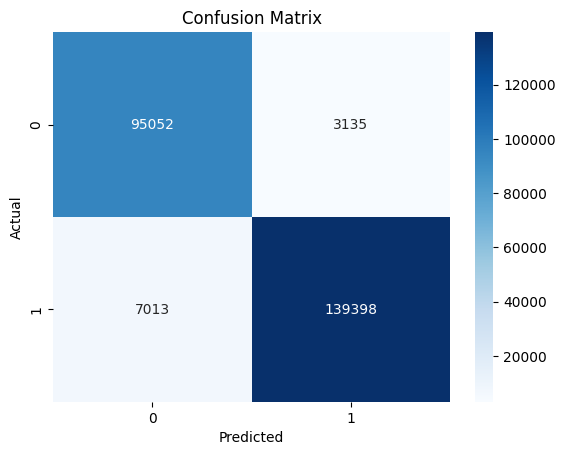

In [24]:
#prediction
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

#confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**ROC AUC SCORE**

ROC AUC Score: 0.9930


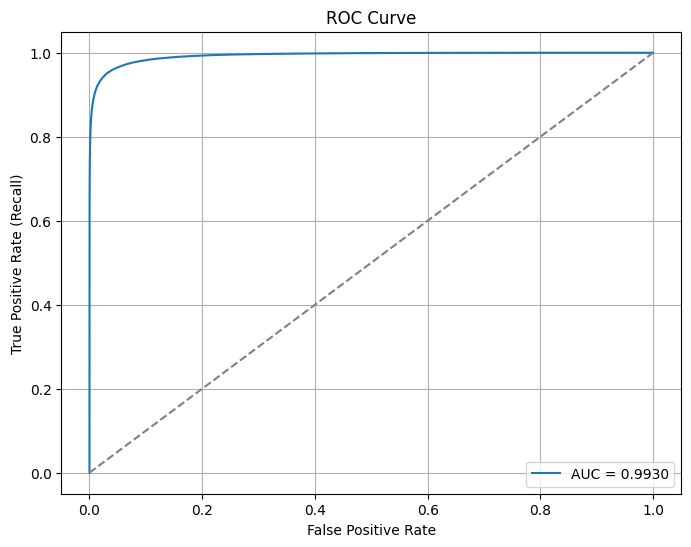

In [25]:
#get predicted probabilities 
#compute ROC AUC score
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

#plot the ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

#calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#plotting
plt.figure(figsize = (8,6))
plt.plot(fpr,tpr,label = f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],linestyle ='--', color = 'gray') #random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

**LOG LOSS**

In [26]:
#predict probabilities

#compute log loss
from sklearn.metrics import log_loss
logloss = log_loss(y_test, y_pred_prob)
print(f"Log Loss: {logloss:.4f}")

Log Loss: 0.1137


**SAVE THE MODEL**

In [27]:
model.save("model_lstm_glovetrainable.h5")
model.save("model_lstm_glovetrainable.keras")

**EMBEDDING MATRIX**

In [28]:
np.save("embedding_matrix.npy", embedding_matrix)

**PLOT CONFIDENCE DISTRIBUTION**

7644/7644 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step


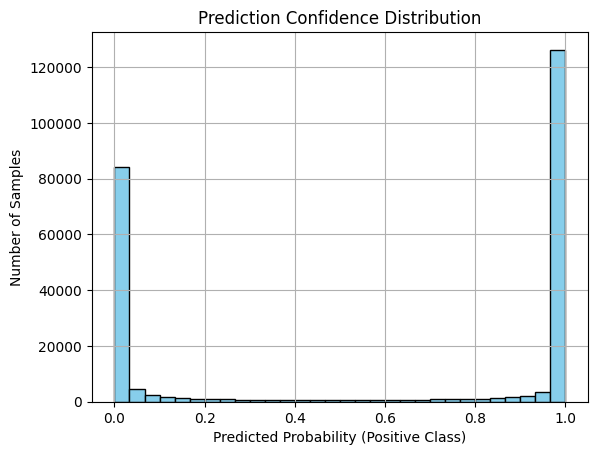

In [29]:
import matplotlib.pyplot as plt

# Get predicted probabilities on test set
y_pred_prob = model.predict(X_test_pad)

plt.hist(y_pred_prob, bins=30, color='skyblue', edgecolor='black')
plt.title("Prediction Confidence Distribution")
plt.xlabel("Predicted Probability (Positive Class)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


**PRECISION RECALL CURVE**

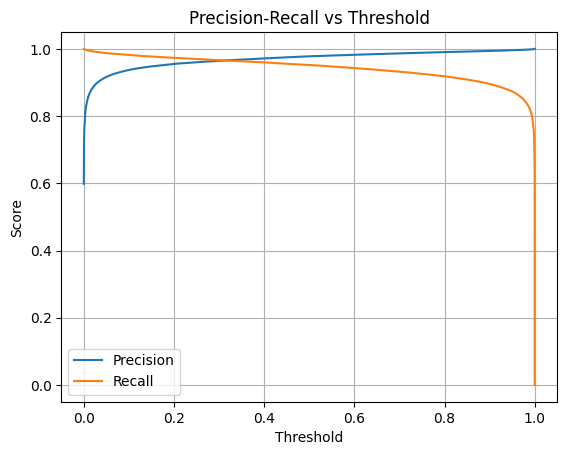

In [30]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.title("Precision-Recall vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


**FIND THE BEST THRESHOLD BY F1 SCORE**  
cut off point that turns a model's probability output into a class label  
this is the model output for POSITIVE CLASS  
0.92 -> very confident its positive
0.04 -> very confident its negative
0.48 -> unsure  

the probability must be converted into a discrete class 0 or 1 using a threshold

threshold 0.5 -> the model only predicts "positive" when its more than 50% sure. conservative
threshold 0.37 - the model allows positive even if its just 37% confident. more inclusive. favors recall

In [32]:
import numpy as np
from sklearn.metrics import f1_score

# Initialize tracking
best_thresh = 0.0
best_f1 = 0.0
f1_scores = []

# Evaluate F1 for thresholds between 0.1 and 0.9
thresholds = np.arange(0.1, 0.91, 0.01)
for thresh in thresholds:
    y_pred_thresh = (y_pred_prob > thresh).astype("int32")
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.2f} with F1 score: {best_f1:.4f}")


Best threshold: 0.37 with F1 score: 0.9659


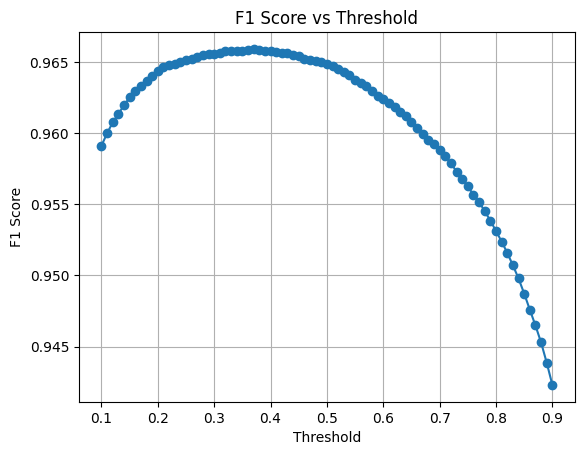

In [33]:
import matplotlib.pyplot as plt

plt.plot(thresholds, f1_scores, marker='o')
plt.title("F1 Score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

**USE 0.37 (BEST THRESHOLD) FOR FINAL PREDICTION**

In [ ]:
y_pred_final = (y_pred_prob > 0.37).astype("int32")
#gives maximum f1 performance

In [35]:
from sklearn.metrics import classification_report

print("Final model evaluation at best threshold (0.37):")
print(classification_report(y_test, y_pred_final))


Final model evaluation at best threshold (0.37):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     98187
           1       0.97      0.96      0.97    146411

    accuracy                           0.96    244598
   macro avg       0.96      0.96      0.96    244598
weighted avg       0.96      0.96      0.96    244598

